## SPATIAL ANALYSIS

In [1]:
import os
import requests

import numpy as np
import pandas as pd
import seaborn as sns

import folium
import geopandas as gpd
import fiona
import shapely


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import zipfile
from zipfile import ZipFile
from sklearn.neighbors import NearestNeighbors
from haversine import haversine, Unit

In [2]:
from astropy.stats import RipleysKEstimator

In [3]:
# For G-function 
import scipy.spatial
#import libpysal as ps
import numpy as np
from pointpats import PointPattern, PoissonPointProcess, as_window, G, F, J, K, L, Genv, Fenv, Jenv, Kenv, Lenv, Window
%matplotlib inline
import matplotlib.pyplot as plt

# Spatial Analysis

In [5]:
os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Data')
df = pd.read_csv('Data_incidents.csv.zip')

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
#MASS SHOOTINGS
mass_shootings = df[df['Mass Shooting']== True].reset_index()

In [7]:
X_ms = np.array(mass_shootings[['latitude','longitude']]) # extract the long-lat columns for KKN analysis

## MASS-SHOOTING NEIGHBOUR

In [8]:
X_ms = np.radians(X_ms)
kkn = NearestNeighbors(n_neighbors=2, algorithm='auto', metric='haversine').fit(X_ms)
distance, indices = kkn.kneighbors()

In [9]:
distances_ms = []
for i in range(len(distance)):
    dist = distance[i][1] * 6371
    distances_ms.append(dist)

In [10]:
nn_ms = pd.DataFrame(distances_ms, columns = ['ms_distance']);

In [11]:
# The columns to dataframe
mass_shootings['MS_Dist'] = nn_ms

In [12]:
#extract relevant columns
ms_nn = mass_shootings[['state','MS_Dist']]

In [13]:
ms_nn_desc_state = ms_nn.groupby(['state']).describe().reset_index() 

In [14]:
sorted_ms_nn_desc_state = ms_nn_desc_state.sort_values(('MS_Dist', 'count'), ascending=False).round(2)

#make range columns
sorted_ms_nn_desc_state['MS_Range'] = sorted_ms_nn_desc_state[('MS_Dist',   'min')].map(str) +'-'+ sorted_ms_nn_desc_state[('MS_Dist',   'max')].map(str)

In [15]:
print(sorted_ms_nn_desc_state.iloc[:, [0,1,2,-1]].to_latex(index=False))

\begin{tabular}{lrrl}
\toprule
          state & \multicolumn{2}{l}{MS\_Dist} &       MS\_Range \\
                &   count & \multicolumn{2}{l}{mean} \\
\midrule
     California &   155.0 &   13.46 &    0.47-299.32 \\
       Illinois &   133.0 &    6.96 &    0.22-112.31 \\
        Florida &   102.0 &   16.12 &     0.28-129.1 \\
          Texas &    84.0 &   33.24 &    1.84-258.57 \\
       New York &    64.0 &    7.39 &    0.15-117.63 \\
        Georgia &    63.0 &   21.53 &    0.48-107.45 \\
      Louisiana &    54.0 &   11.57 &    0.75-116.26 \\
           Ohio &    54.0 &   17.01 &     0.89-97.54 \\
   Pennsylvania &    52.0 &   11.75 &    0.76-130.51 \\
      Tennessee &    52.0 &   14.26 &    1.16-153.51 \\
       Michigan &    45.0 &   15.74 &     0.92-92.87 \\
       Missouri &    42.0 &   20.94 &    0.89-170.71 \\
     New Jersey &    38.0 &    7.81 &     0.76-59.78 \\
       Virginia &    35.0 &   22.75 &     0.98-83.02 \\
        Indiana &    34.0 &    9.08 &      1.0-63.24

# G-function

### Area definition

In [16]:
ms_cali = mass_shootings[mass_shootings['state'] =='California'].reset_index()
ms_cali=ms_cali.drop(columns = 'index')


northeast = ['Illinois','Wisconsin','Michigan','Indiana']
ms_northeast= mass_shootings.loc[mass_shootings['state'].isin(northeast)].reset_index()
ms_northeast=ms_northeast.drop(columns = 'index')

middleatlantic = ['Connecticut','Massachusetts','Delaware','Maryland','New York','Pennsylvania','New Jersey']
ms_midatlantic= mass_shootings.loc[mass_shootings['state'].isin(middleatlantic)].reset_index()
ms_midatlantic=ms_midatlantic.drop(columns = 'index')

### Relevant state definitions 

In [17]:
cali_ll = ms_cali[['latitude', 'longitude']]
NE_ll = ms_northeast[['latitude', 'longitude']]
MA_ll = ms_midatlantic[['latitude', 'longitude']]

In [18]:
pp_cali = PointPattern(cali_ll)
pp_NE = PointPattern(NE_ll)
pp_MA = PointPattern(MA_ll)

In [19]:
pp_cali.summary()

Point Pattern
155 points
Bounding rectangle [(32.5866,-122.819), (41.4838,-116.18)]
Area of window: 59.068510799999984
Intensity estimate for window: 2.6240715721582073
         x        y
0  33.9593 -118.278
1  37.7752 -122.221
2  37.9595 -121.277
3  41.4838 -120.545
4  33.7869 -118.278


In [20]:
g_cali = G(pp_cali, intervals = 50, dmax=1.5)
g_NE = G(pp_NE, intervals = 50, dmax=1.5)
g_MA = G(pp_MA, intervals = 50, dmax=1.5)

### G function - California

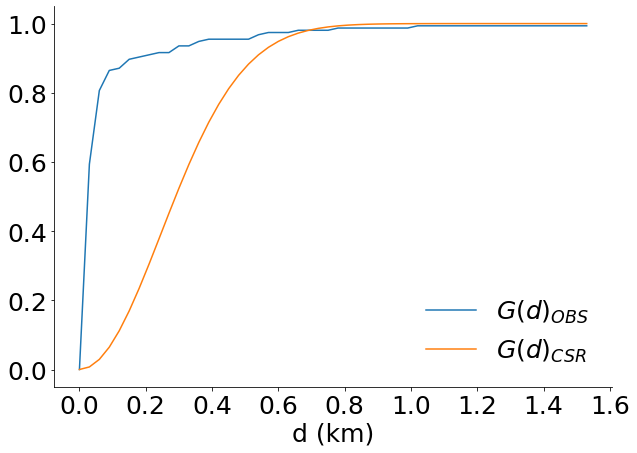

In [21]:
fig_cali_g, ax = plt.subplots(1, figsize=(10, 7))
g_cali.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('d (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$G(d)_{OBS}$')
L.get_texts()[1].set_text('$G(d)_{CSR}$')

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig_cali_g.savefig("G_cali.pdf", bbox_inches='tight')

### G function - North East Central

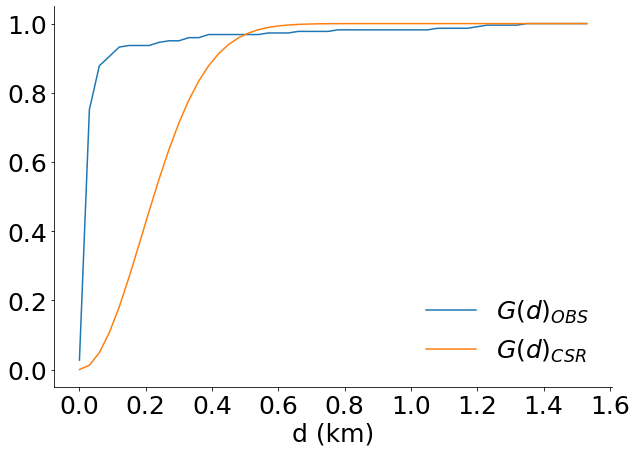

In [22]:
fig_NE_g, ax = plt.subplots(1, figsize=(10, 7))
g_NE.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('d (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$G(d)_{OBS}$')
L.get_texts()[1].set_text('$G(d)_{CSR}$')

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig_NE_g.savefig("G_NE.pdf", bbox_inches='tight')

### G function - Mid-Atlantic

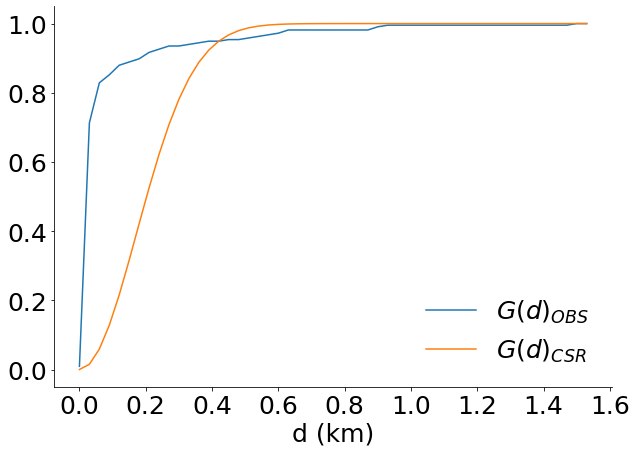

In [23]:
fig_MA_g, ax = plt.subplots(1, figsize=(10, 7))
g_MA.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('d (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$G(d)_{OBS}$')
L.get_texts()[1].set_text('$G(d)_{CSR}$')

os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig_MA_g.savefig("G_MA.pdf", bbox_inches='tight')

# K-Function

In [24]:
k_cali = K(pp_cali, intervals=50, dmax=1.5)
k_NE = K(pp_NE, intervals=50, dmax=1.5)
k_MA = K(pp_MA, intervals=50, dmax=1.5)

### K function - California

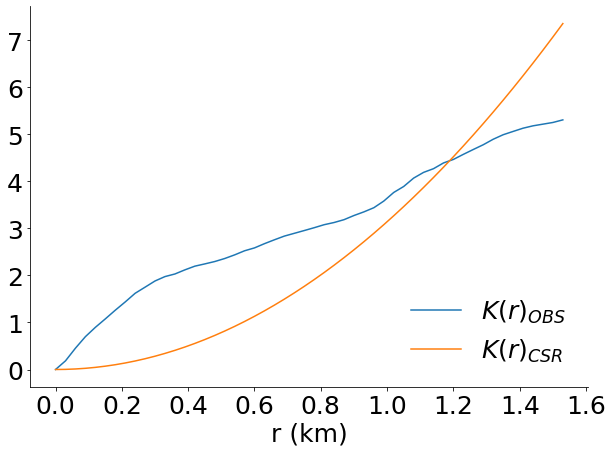

In [25]:
fig, ax = plt.subplots(1, figsize=(10, 7))
k_cali.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('r (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$K(r)_{OBS}$')
L.get_texts()[1].set_text('$K(r)_{CSR}$')


os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig.savefig("K_cali.pdf", bbox_inches='tight')

### K function - North East Central

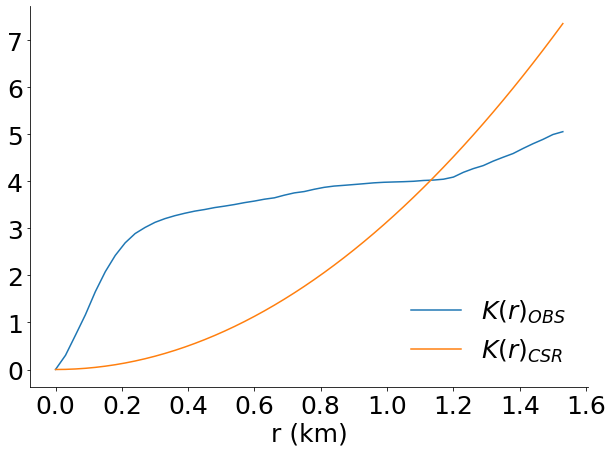

In [26]:
fig, ax = plt.subplots(1, figsize=(10, 7))
k_NE.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('r (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$K(r)_{OBS}$')
L.get_texts()[1].set_text('$K(r)_{CSR}$')


os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig.savefig("K_NE.pdf", bbox_inches='tight')

### K function - Mid-Atlantic

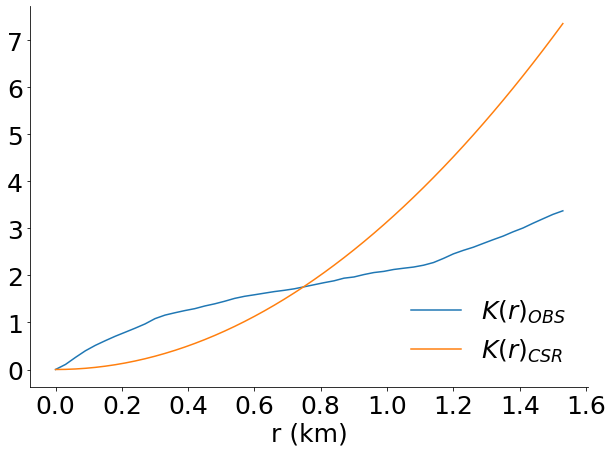

In [27]:
fig, ax = plt.subplots(1, figsize=(10, 7))
k_MA.plot()
plt.title('')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('', fontsize = 25);
plt.yticks(fontsize = 25);
plt.xlabel('r (km)', fontsize = 25);
plt.xticks(fontsize = 25);

L = plt.legend(loc=4, prop={'size': 25}, frameon=False)
L.get_texts()[0].set_text('$K(r)_{OBS}$')
L.get_texts()[1].set_text('$K(r)_{CSR}$')


os.chdir('/Users/josefinebjornholm/Documents/GitHub/Gun_Violence_E19/Figures')
fig.savefig("K_MA.pdf", bbox_inches='tight')